# 2η ατομική εργασία στη Τεχνολογία και Ανάλυση Εικόνων και Βίντεο

## Κωνσταντίνος Δαλαμπέκης - 03120055

## 1 . Θεωρητικό Μέρος

### Θεωρητικό Μέρος

#### Συγκριτικός Πίνακας LeNet, AlexNet, VGG

| Μοντέλο | Επίπεδα | Μέγεθος φίλτρων | Συνάρτηση ενεργοποίησης | Πλήθος παραμέτρων | Pooling | Dropout |
|--------|---------|------------------|---------------------------|--------------------|---------|---------|
| LeNet-5 | 5 | 5×5 | sigmoid | ~60.000 | Average Pooling | Όχι |
| AlexNet | 8 | 11×11, 5×5, 3×3 | ReLU | ~60.000.000 | Max Pooling | Ναι (0.5) |
| VGG-11 | 11 | 3×3 | ReLU | ~132.000.000 | Max Pooling | Ναι (0.5) |

---


- **LeNet-5**: Από τα πρώτα CNN, σχεδιασμένο για το MNIST. Είναι ρηχό, με λίγες παραμέτρους και μικρό βάθος. Κατάλληλο για απλά προβλήματα αναγνώρισης.

- **AlexNet**: Επανάσταση στο ImageNet το 2012. Εισήγαγε ReLU και dropout. Πολύ πιο βαθύ από το LeNet, με χρήση GPU για εκπαίδευση. Πολύ καλύτερη απόδοση σε σύνθετα datasets.

- **VGG-11**: Χρησιμοποιεί αποκλειστικά φίλτρα 3×3 και αυστηρά ορισμένα blocks με Max Pooling. Είναι βαθύ αλλά πιο απλό από το VGG-16. Διαθέτει μεγάλο αριθμό παραμέτρων και χρησιμοποιείται ευρέως για μεταφορά μάθησης. Υπολογιστικά απαιτητικό.

## 2. Υλοποίηση Αλγορίθμου

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# helper functions

# select from from_list elements with index in index_list
def select_from_list(from_list, index_list):
  filtered_list= [from_list[i] for i in index_list]
  return(filtered_list)

# append in filtered_list the index of each element of unfilterd_list if it exists in in target_list
def get_ds_index(unfiliterd_list, target_list):
  index = 0
  filtered_list=[]
  for i_ in unfiliterd_list:
    if i_[0] in target_list:
      filtered_list.append(index)
    index += 1
  return(filtered_list)


In [3]:
# load the entire dataset
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

(x_train_all, y_train_all), (x_test_all, y_test_all) = tf.keras.datasets.cifar100.load_data(label_mode='fine')

In [5]:
# REPLACE WITH YOUR TEAM NUMBER
team_seed = 55

In [6]:
# select from CIFAR100 20 classes
cifar100_classes_url = "https://pastebin.com/raw/nzE1n98V"

In [7]:
import pandas as pd
import requests
from io import StringIO

# Function to fetch CSV-like data from Pastebin with browser headers
def fetch_pastebin_csv(url):
    headers = {'User-Agent': 'Mozilla/5.0'}  # Spoof a browser
    response = requests.get(url, headers=headers)
    response.raise_for_status()  # Raise error if something goes wrong
    return pd.read_csv(StringIO(response.text), sep=',', header=None)

# Load both pastebin datasets
team_classes = fetch_pastebin_csv("https://pastebin.com/raw/nzE1n98V")
CIFAR100_LABELS_LIST = fetch_pastebin_csv("https://pastebin.com/raw/qgDaNggt").astype(str).values.tolist()[0]


In [8]:
# select the classes for the team
# team_classes is a dataframe with 20 classes for each team
    
our_index = team_classes.iloc[team_seed,:].values.tolist()
our_classes = select_from_list(CIFAR100_LABELS_LIST, our_index)
train_index = get_ds_index(y_train_all, our_index)
test_index = get_ds_index(y_test_all, our_index)

x_train_ds = np.asarray(select_from_list(x_train_all, train_index))
y_train_ds = np.asarray(select_from_list(y_train_all, train_index))
x_test_ds = np.asarray(select_from_list(x_test_all, test_index))
y_test_ds = np.asarray(select_from_list(y_test_all, test_index))

In [9]:
# print our classes
print(our_classes)

[' baby', ' bee', ' caterpillar', ' cockroach', ' crab', ' dinosaur', ' girl', ' leopard', ' lobster', ' mushroom', ' otter', ' pickup_truck', ' poppy', ' rabbit', ' seal', ' squirrel', ' sunflower', ' table', ' tiger', ' wolf']


Train: X=(8500, 32, 32, 3), y=(8500, 1)
Validation: X=(1500, 32, 32, 3), y=(1500, 1)
Test: X=(2000, 32, 32, 3), y=(2000, 1)


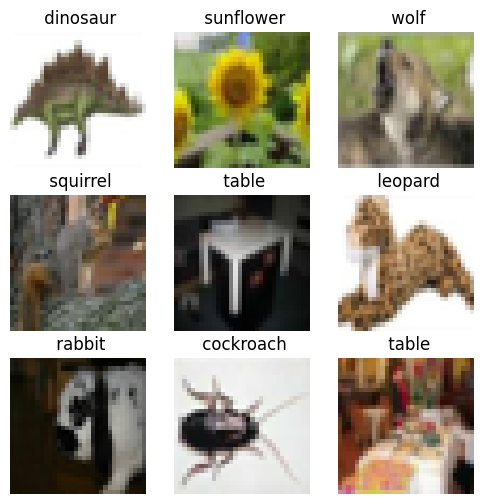

In [11]:
# get (train) dataset dimensions
data_size, img_rows, img_cols, img_channels = x_train_ds.shape

# set validation set percentage (wrt the training set size)
validation_percentage = 0.15
val_size = round(validation_percentage * data_size)

# Reserve val_size samples for validation and normalize all values
x_val = x_train_ds[-val_size:]/255
y_val = y_train_ds[-val_size:]
x_train = x_train_ds[:-val_size]/255
y_train = y_train_ds[:-val_size]
x_test = x_test_ds/255
y_test = y_test_ds

# summarize loaded dataset
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Validation: X=%s, y=%s' % (x_val.shape, y_val.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

# get class label from class index
def class_label_from_index(fine_category):
  return(CIFAR100_LABELS_LIST[fine_category.item(0)])

# plot first few images
plt.figure(figsize=(6, 6))
for i in range(9):
	# define subplot
  plt.subplot(330 + 1 + i).set_title(class_label_from_index(y_train[i]))
	# plot raw pixel data
  plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
  #show the figure
  plt.axis('off')

plt.show()

### Ερώτημα 1

#### Βήμα 1: Σχεδίαση και εκπαίδευση των μοντέλων

 Σχεδίαστε και εκπαιδεύστε τα μοντέλα  **LeNet, AlexNet και  VGG**, καθώς και ένα δικό σας μοντέλο (ονομάστε το π.χ. **MyCNN**) χρησιμοποιώντας τον ίδιο αλγορίθμο βελτιστοποίησης ([optimizer](https://keras.io/api/optimizers/)), την ίδια συνάρτηση κόστους [loss function](https://keras.io/api/losses/), το ίδιο μέγεθος παρτίδας (batch size) και 50 εποχές (epochs) `*`.

 Για την εκτίμηση της απόδοσης των μοντέλων να χρησιμοποιήσετε ως μετρική ([metrics](https://keras.io/api/metrics/)) την F1-score.


`*`
 Μπορείτε να πειραματιστείτε με τον optimizer, την loss function και το batch size για τα 4 μοντέλα πριν καταλήξετε στην τελική σας κοινή, για όλα τα μοντέλα επιλογή.

In [12]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [13]:
def preprocess_data(x_train, y_train, x_val, y_val, x_test, y_test):
  # Remapping the labels so that they are between 1-20
  label_mapping = {original_label: new_label for new_label, original_label in enumerate(our_index)}
  y_train_remapped = np.array([label_mapping[label.item()] for label in y_train])
  y_val_remapped = np.array([label_mapping[label.item()] for label in y_val])
  y_test_remapped = np.array([label_mapping[label.item()] for label in y_test])

  # Convert to tensors
  x_train_tensor = torch.tensor(x_train.transpose(0, 3, 1, 2), dtype=torch.float32)
  y_train_tensor = torch.tensor(y_train_remapped.squeeze(), dtype=torch.long)

  x_val_tensor = torch.tensor(x_val.transpose(0, 3, 1, 2), dtype=torch.float32)
  y_val_tensor = torch.tensor(y_val_remapped.squeeze(), dtype=torch.long)

  x_test_tensor = torch.tensor(x_test.transpose(0, 3, 1, 2), dtype=torch.float32)
  y_test_tensor = torch.tensor(y_test_remapped.squeeze(), dtype=torch.long)

  # Create datasets and loaders
  train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
  val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
  test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

  train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

  return train_loader, val_loader, test_loader

In [14]:
# LeNet
class LeNet(nn.Module):
  def __init__(self, lr=0.1, num_classes=len(our_classes)):
    super().__init__()
    self.model = nn.Sequential(
        nn.Conv2d(3, 6, kernel_size=5, padding=2),
        nn.Sigmoid(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Conv2d(6, 16, kernel_size=5),
        nn.Sigmoid(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(16 * 6 * 6, 120),
        nn.Sigmoid(),
        nn.Linear(120, 84),
        nn.Sigmoid(),
        nn.Linear(84, num_classes)
    )

  def forward(self, x):
    return self.model(x)

In [15]:
# AlexNet
class AlexNet(nn.Module):
  def __init__(self, lr=0.001, num_classes=len(our_classes)):
    super().__init__()
    self.features = nn.Sequential(
        nn.Conv2d(3, 96, kernel_size=11, stride=2, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Conv2d(96, 256, kernel_size=5, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Conv2d(256, 384, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(384, 384, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(384, 256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(256 * 1 * 1, 4096),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(),
        nn.Linear(4096, num_classes)
    )

  def forward(self, x):
    x = self.features(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x

In [16]:
# VGG
class VGG(nn.Module):
  def __init__(self, lr=0.001, num_classes=len(our_classes)):
    super().__init__()
    self.features = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(256, 512, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.classifier = nn.Sequential(
        nn.Linear(512 * 1 * 1, 4096),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(4096, 4096),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(4096, num_classes)
    )

  def forward(self, x):
    x = self.features(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x

In [ ]:
class ExampleCNN(nn.Module):
    def __init__(self, lr=0.001, num_classes=len(our_classes), dropout1=0.25, dropout2=0.5):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout1),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout1),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout1),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(dropout2),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [18]:
# Check if cuda is available to use
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [19]:
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=50):
  model.to(device)
  train_f1_scores = []
  val_f1_scores = []

  for epoch in range(epochs):
    model.train()
    y_true_train, y_pred_train = [], []

    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels.squeeze())
      loss.backward()
      optimizer.step()

      y_pred = outputs.argmax(dim=1)
      y_true_train.extend(labels.cpu().numpy())
      y_pred_train.extend(y_pred.cpu().numpy())

    # Calculate f1-scores
    train_f1 = f1_score(y_true_train, y_pred_train, average='macro')
    train_f1_scores.append(train_f1)

    # Validation phase
    model.eval()
    y_true_eval, y_pred_eval = [], []
    with torch.no_grad():
      for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        y_pred = outputs.argmax(dim=1)
        y_true_eval.extend(labels.cpu().numpy())
        y_pred_eval.extend(y_pred.cpu().numpy())

    val_f1 = f1_score(y_true_eval, y_pred_eval, average='macro')
    val_f1_scores.append(val_f1)

    if epoch % 5 == 4:
      print(f'Epoch {epoch+1}/{epochs}, Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}')

  return train_f1_scores, val_f1_scores

In [ ]:
# List of models
models = {
    "LeNet": LeNet(),
    "AlexNet": AlexNet(),
    "VGG": VGG(),
    "ExampleCNN": ExampleCNN()
}

# List of f1-scores
f1_scores_dict ={
    "LeNet": (None, None),
    "AlexNet": (None, None),
    "VGG": (None, None),
    "ExampleCNN": (None, None)
}

# Common settings
criterion = nn.CrossEntropyLoss()
EPOCHS = 50

# Prepare dataset
train_loader, val_loader, test_loader = preprocess_data(x_train, y_train, x_val, y_val, x_test, y_test)

# Train, evaluate, and save models
for name, model in models.items():
    print(f"\n--- Training {name} ---")

    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train model
    train_f1, val_f1 = train_model(model, train_loader, val_loader, optimizer, criterion, epochs=EPOCHS)

    # Save f1 values
    f1_scores_dict[name] = (train_f1, val_f1)

    save_dir = "saved_models"
    os.makedirs(save_dir, exist_ok=True)

    # Save the model using the same 'name' variable
    model_path = os.path.join(save_dir, f"{name}.pth")
    torch.save(model.state_dict(), model_path)

    print(f"Saved {name} to {model_path}")



--- Training LeNet ---
Epoch 5/50, Train F1: 0.0802, Val F1: 0.0376
Epoch 10/50, Train F1: 0.0966, Val F1: 0.0713
Epoch 15/50, Train F1: 0.1261, Val F1: 0.1004
Epoch 20/50, Train F1: 0.1647, Val F1: 0.1403
Epoch 25/50, Train F1: 0.2012, Val F1: 0.1781
Epoch 30/50, Train F1: 0.2419, Val F1: 0.2335
Epoch 35/50, Train F1: 0.2743, Val F1: 0.2458
Epoch 40/50, Train F1: 0.3005, Val F1: 0.2618
Epoch 45/50, Train F1: 0.3368, Val F1: 0.2922
Epoch 50/50, Train F1: 0.3643, Val F1: 0.3116
Saved LeNet to saved_models/LeNet.pth

--- Training AlexNet ---
Epoch 5/50, Train F1: 0.1018, Val F1: 0.0855
Epoch 10/50, Train F1: 0.2027, Val F1: 0.1875
Epoch 15/50, Train F1: 0.2737, Val F1: 0.2600
Epoch 20/50, Train F1: 0.3420, Val F1: 0.3024
Epoch 25/50, Train F1: 0.4203, Val F1: 0.2945
Epoch 30/50, Train F1: 0.4868, Val F1: 0.3233
Epoch 35/50, Train F1: 0.5751, Val F1: 0.3346
Epoch 40/50, Train F1: 0.6511, Val F1: 0.3374
Epoch 45/50, Train F1: 0.7253, Val F1: 0.3447
Epoch 50/50, Train F1: 0.7785, Val F1: 0

#### Βήμα 2: Αξιολόγηση των μοντέλων

α. Για κάθε ένα από τα μοντέλα που εκπαιδεύσατε στο Βήμα 1, απεικονίστε σε κοινό διάγραμμα τα F1-scores εκπαίδευσης και επικύρωσης στο σύνολο των εποχών.

In [25]:
def plot_f1_scores(f1_scores_dict):
    epochs = len(next(iter(f1_scores_dict.values()))[0])  

    # Plot Training F1-scores
    plt.figure(figsize=(10, 5))
    for model_name, (train_f1, _) in f1_scores_dict.items():
        plt.plot(range(1, epochs + 1), train_f1, label=f'{model_name} - Train')
    plt.title('Training F1-Score per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('F1-score')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Validation F1-scores
    plt.figure(figsize=(10, 5))
    for model_name, (_, val_f1) in f1_scores_dict.items():
        plt.plot(range(1, epochs + 1), val_f1, label=f'{model_name} - Validation')
    plt.title('Validation F1-Score per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('F1-score')
    plt.legend()
    plt.grid(True)
    plt.show()

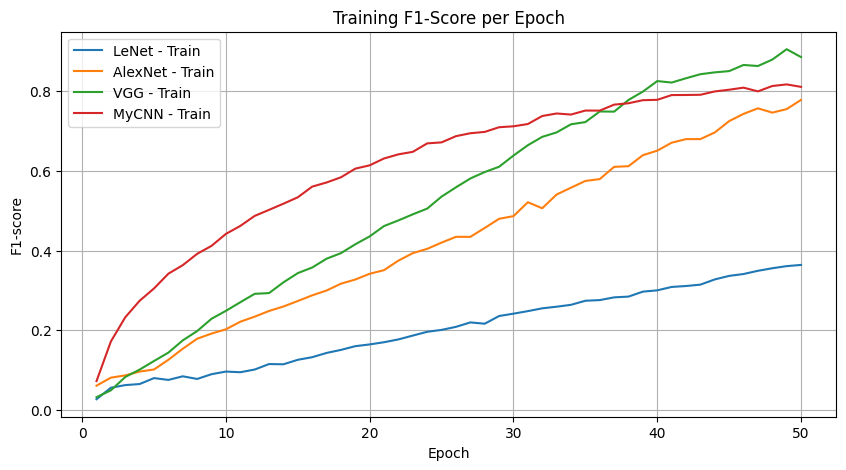

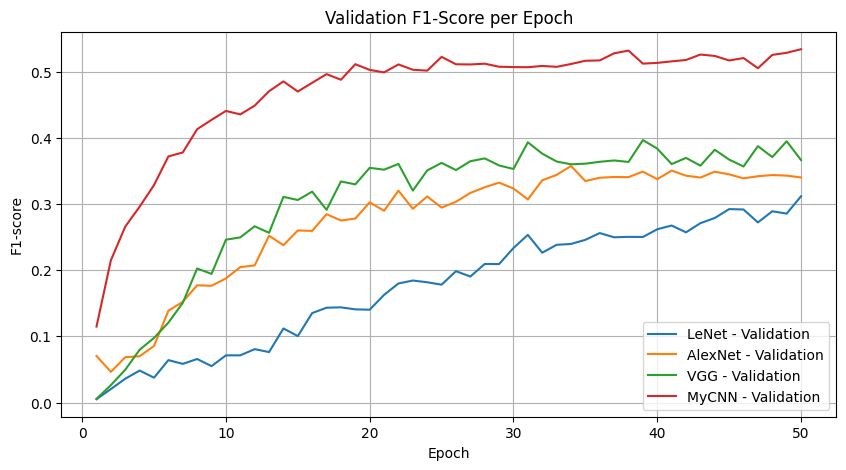

In [26]:
plot_f1_scores(f1_scores_dict)

β. Αξιολογήστε, αναλυτικά, τα αποτελέσματά σας ως προς τα εξής:

i. Επίδραση του πλήθους των δεδομένων/κλάσεων.

ii. Επίδραση του αλγόριθμου βελτιστοποίησης (optimizer)

iii. Επίδραση του μεγέθους δέσμης (batch size)

i. Το μεγάλο πλήθος κλάσεων (100 στο CIFAR-100, εκ των οποίων χρησιμοποιήσαμε τα 20) καθιστά την ταξινόμηση πιο απαιτητική, ιδιαίτερα για πιο απλά δίκτυα όπως το LeNet. Παρατηρήθηκε ότι βαθύτερα δίκτυα όπως το VGG-11 και το AlexNet διαχειρίζονται καλύτερα την πολυπλοκότητα των δεδομένων, επιτυγχάνοντας υψηλότερα F1-scores.

ii. Ο Adam ως βελτιστοποιητής παρουσίασε ταχύτερη σύγκλιση και πιο σταθερά F1-scores. Αντιθέτως, η χρήση του SGD απαιτούσε προσεκτική ρύθμιση του learning rate και οδηγούσε σε πιο αργή σύγκλιση. Για όλα τα μοντέλα, ο Adam παρείχε καλύτερα αποτελέσματα χωρίς εκτεταμένο fine-tuning.

iii. Η χρήση batch size = 64 αποτέλεσε μια ισορροπημένη επιλογή ανάμεσα σε ταχύτητα και σταθερότητα εκπαίδευσης. Μικρότερο batch size (32) αύξησε τη στοχαστικότητα, προκαλώντας διακυμάνσεις στην απόδοση, ενώ μεγαλύτερο (128) επιτάχυνε την εκπαίδευση αλλά μείωσε την ικανότητα γενίκευσης.

#### Βήμα 3: Αξιολόγηση F1-score
Αξιολογήστε τα F1-scores, χρησιμοποιώντας το σύνολο ελέγχου σας (test set).

In [27]:
def test_model(model, test_loader):
  model.eval()
  y_true_test, y_pred_test = [], []
  with torch.no_grad():
    for images, labels in test_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      y_pred = outputs.argmax(dim=1)
      y_true_test.extend(labels.cpu().numpy())
      y_pred_test.extend(y_pred.cpu().numpy())

  test_f1 = f1_score(y_true_test, y_pred_test, average='macro')
  print(f"Test F1-score: {test_f1:.4f}")

In [28]:
# Test models
for name, model in models.items():
    print(f"\n--- Testing {name} ---")
    test_model(model, test_loader)


--- Testing LeNet ---
Test F1-score: 0.3192

--- Testing AlexNet ---
Test F1-score: 0.3576

--- Testing VGG ---
Test F1-score: 0.3824

--- Testing MyCNN ---
Test F1-score: 0.5482


### Ερώτημα 2

#### Βήμα 1: Έλεγχος υπερεκπαίδευσης

Για μοντέλο σας  (**ExampleCNN**) και μόνο, δοκιμάστε διάφορους συνδυασμούς των ακόλουθων τεχνικών για τον έλεγχο της υπερεκπαίδευσης (overfitting), ώστε το μοντέλο σας να γενικεύει καλύτερα, όπως:

- Dropout ([Dropout](https://www.tensorflow.org/tutorials/images/classification#dropout))

- Επαύξηση δεδομένων ([Data augmentation](https://www.tensorflow.org/tutorials/images/classification#data_augmentation), [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#class_imagedatagenerator))

Το βασικό μοντέλο ExampleCNN έχει ήδη κατασκευαστεί με χρήση Dropout. Θα δοκιμάσουμε, λοιπόν, διαφορετικές παραλλαγές με και χωρίς χρήση data augmentation:


In [29]:
# Augmentation function
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(90),
    transforms.RandomResizedCrop(32, scale=(0.6, 1.0)),
])

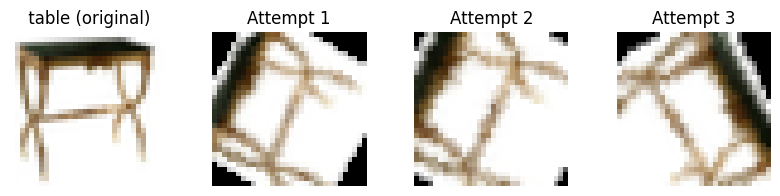

In [30]:
# Test the augmentation
def test_augment():
  i = np.random.randint(0, len(x_test_ds))
  img = x_test_ds[i]
  img = Image.fromarray(img, mode='RGB')

  plt.figure(figsize=(10, 2))
  plt.subplot(1, 4, 1)
  plt.imshow(img)
  plt.title(f"{class_label_from_index(y_test_ds[i])} (original)")
  plt.axis('off')

  for j in range(3):
    aug = augmentation(img)
    plt.subplot(1, 4, j+2)
    plt.imshow(aug)
    plt.title(f"Attempt {j+1}")
    plt.axis('off')
  plt.show()

test_augment()

In [31]:
from torchvision.transforms import ToTensor
from tqdm import tqdm

# Convert original arrays to PIL and apply augmentation
def augment_dataset(x_ds, y_ds, n_augmented=2):
  augmented_images = []
  augmented_labels = []

  for id in tqdm(range(len(x_ds))):
    img_array = x_ds[id]
    label = y_ds[id]
    img = Image.fromarray(img_array, mode='RGB')

    # Add original image
    augmented_images.append(img_array)
    augmented_labels.append(label)

    # Create n augmented versions
    for _ in range(n_augmented):
      aug_img = augmentation(img)
      aug_img_np = np.array(aug_img)
      augmented_images.append(aug_img_np)
      augmented_labels.append(label)

  return augmented_images, augmented_labels


print("Augmenting train dataset...")
train_images, train_labels = augment_dataset(x_train_ds, y_train_ds)
print(f"New dataset size: {len(train_images)}")

print("\nAugmenting test dataset...")
test_images, test_labels = augment_dataset(x_test_ds, y_test_ds)
print(f"New dataset size: {len(test_images)}")

# Convert lists to Numpy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

Augmenting train dataset...


100%|██████████| 10000/10000 [00:01<00:00, 5762.79it/s]


New dataset size: 30000

Augmenting test dataset...


100%|██████████| 2000/2000 [00:00<00:00, 5821.60it/s]

New dataset size: 6000


Train: X=(25500, 32, 32, 3), y=(25500, 1)
Validation: X=(4500, 32, 32, 3), y=(4500, 1)
Test: X=(6000, 32, 32, 3), y=(6000, 1)


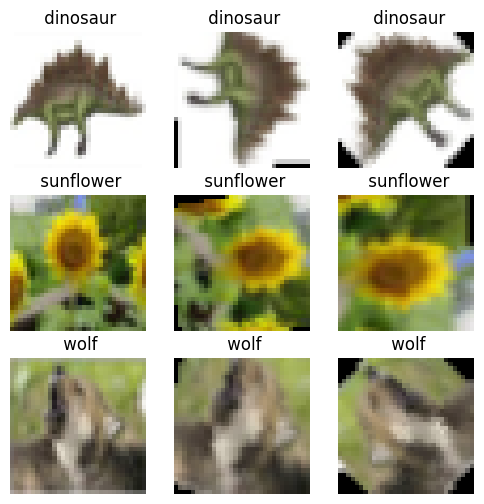

In [32]:
# get (train) dataset dimensions
data_size, img_rows, img_cols, img_channels = train_images.shape

# set validation set percentage (wrt the training set size)
validation_percentage = 0.15
val_size = round(validation_percentage * data_size)

# Reserve val_size samples for validation and normalize all values
x_val_aug = train_images[-val_size:]/255
y_val_aug = train_labels[-val_size:]
x_train_aug = train_images[:-val_size]/255
y_train_aug = train_labels[:-val_size]
x_test_aug = test_images/255
y_test_aug = test_labels

# summarize loaded dataset
print('Train: X=%s, y=%s' % (x_train_aug.shape, y_train_aug.shape))
print('Validation: X=%s, y=%s' % (x_val_aug.shape, y_val_aug.shape))
print('Test: X=%s, y=%s' % (x_test_aug.shape, y_test_aug.shape))

# get class label from class index
def class_label_from_index(fine_category):
  return(CIFAR100_LABELS_LIST[fine_category.item(0)])

# plot first few images
plt.figure(figsize=(6, 6))
for i in range(9):
	# define subplot
  plt.subplot(330 + 1 + i).set_title(class_label_from_index(y_train_aug[i]))
	# plot raw pixel data
  plt.imshow(x_train_aug[i], cmap=plt.get_cmap('gray'))
  #show the figure
  plt.axis('off')

plt.show()

In [ ]:
# Configurations
configs = {
    "D(0)-AUG(0)": (0, 0, False),
    "D(0.25)-AUG(0)": (0, 0.25, False),
    "D(0.5)-AUG(0)": (0.25, 0.5, False),
    "D(0.7)-AUG(0)": (0.5, 0.7, False),
    "D(0)-AUG(1)": (0, 0, True),
    "D(0.25)-AUG(1)": (0, 0.25, True),
    "D(0.5)-AUG(1)": (0.25, 0.5, True),
    "D(0.7)-AUG(1)": (0.5, 0.7, True)
    
}

# List of f1-scores
f1_scores_dict ={
    "D(0)-AUG(0)": (None, None),
    "D(0.25)-AUG(0)": (None, None),
    "D(0.5)-AUG(0)": (None, None),
    "D(0.7)-AUG(0)": (None, None),
    "D(0)-AUG(1)": (None, None),
    "D(0.25)-AUG(1)": (None, None),
    "D(0.5)-AUG(1)": (None, None),
    "D(0.7)-AUG(1)": (None, None)
}

# Common settings
criterion = nn.CrossEntropyLoss()
EPOCHS = 50

# Prepare dataset
train_loader_aug, val_loader_aug, test_loader_aug = preprocess_data(x_train_aug, y_train_aug, x_val_aug, y_val_aug, x_test_aug, y_test_aug)

# Train, evaluate, and save models
for name, config in configs.items():
    dropout1, dropout2, use_augmentation = config

    print(f"\n--- Training with {name} configurations ---")
    print(f"- Dropout in conv layers: {dropout1}")
    print(f"- Dropout in fully connected layers: {dropout2}")
    print(f"- Data augmentation: {use_augmentation}")

    # Define model (MyCNN)
    model = ExampleCNN(dropout1=dropout1, dropout2=dropout2)

    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train model
    if use_augmentation:
      f_train_loader = train_loader_aug
      f_val_loader = val_loader_aug
    else:
      f_train_loader = train_loader
      f_val_loader = val_loader
    train_f1, val_f1 = train_model(model, f_train_loader, f_val_loader, optimizer, criterion, epochs=EPOCHS)

    # Save f1 values
    f1_scores_dict[name] = (train_f1, val_f1)

    # Save model
    save_dir = "saved_models"
    os.makedirs(save_dir, exist_ok=True)

    # Save the model using the same 'name' variable
    model_path = os.path.join(save_dir, f"{name}.pth")
    torch.save(model.state_dict(), model_path)

    print(f"Saved {name} to {model_path}")


--- Training with D(0)-AUG(0) configurations ---
- Dropout in conv layers: 0
- Dropout in fully connected layers: 0
- Data augmentation: False
Epoch 5/50, Train F1: 0.4186, Val F1: 0.3710
Epoch 10/50, Train F1: 0.7135, Val F1: 0.4264
Epoch 15/50, Train F1: 0.9514, Val F1: 0.4492
Epoch 20/50, Train F1: 0.9737, Val F1: 0.4701
Epoch 25/50, Train F1: 0.9806, Val F1: 0.4627
Epoch 30/50, Train F1: 0.9868, Val F1: 0.4628
Epoch 35/50, Train F1: 0.9867, Val F1: 0.4340
Epoch 40/50, Train F1: 0.9800, Val F1: 0.4536
Epoch 45/50, Train F1: 0.9760, Val F1: 0.4419
Epoch 50/50, Train F1: 0.9967, Val F1: 0.4586
Saved D(0)-AUG(0) to saved_models/D(0)-AUG(0).pth

--- Training with D(0.25)-AUG(0) configurations ---
- Dropout in conv layers: 0
- Dropout in fully connected layers: 0.25
- Data augmentation: False
Epoch 5/50, Train F1: 0.4067, Val F1: 0.4070
Epoch 10/50, Train F1: 0.6523, Val F1: 0.4667
Epoch 15/50, Train F1: 0.8577, Val F1: 0.4444
Epoch 20/50, Train F1: 0.9317, Val F1: 0.4505
Epoch 25/50, T

#### Βήμα 2: Αξιολόγηση
Αξιολογήστε τα αποτελέσματά σας, βάσει του F1 score για το σύνολο επικύρωσης και για το σύνολο ελέγχου

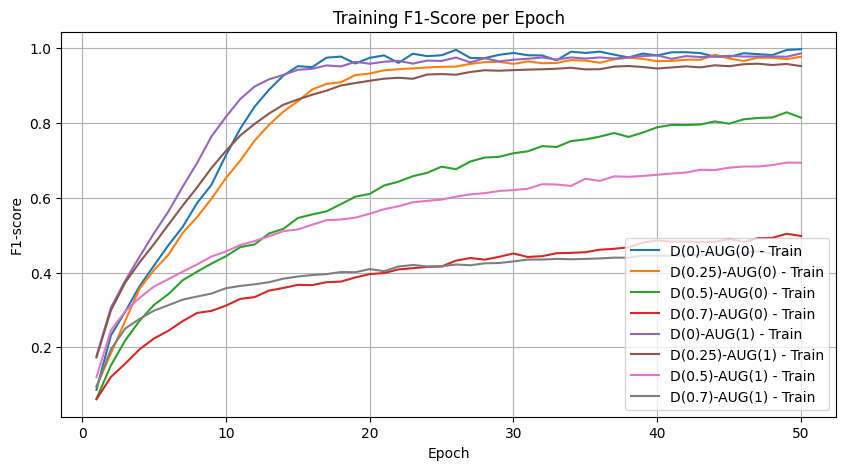

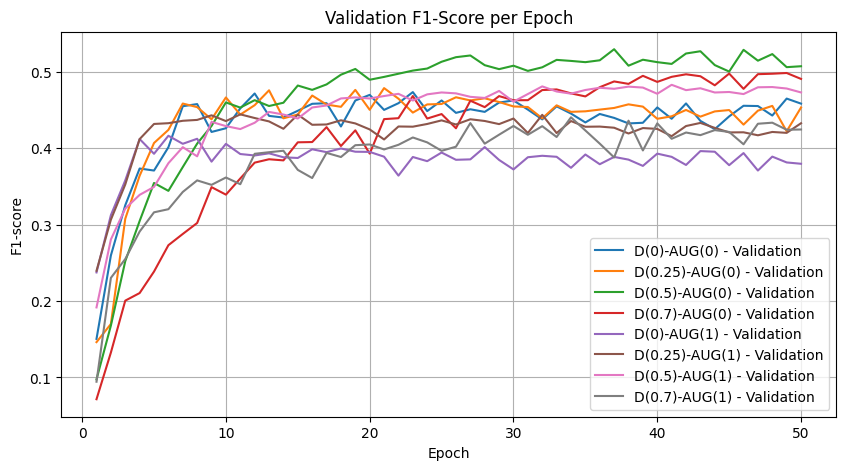


--- Testing D(0)-AUG(0) configurations ---
Test F1-score: 0.4598

--- Testing D(0.25)-AUG(0) configurations ---
Test F1-score: 0.4598

--- Testing D(0.5)-AUG(0) configurations ---
Test F1-score: 0.4598

--- Testing D(0.7)-AUG(0) configurations ---
Test F1-score: 0.4598

--- Testing D(0)-AUG(1) configurations ---
Test F1-score: 0.4282

--- Testing D(0.25)-AUG(1) configurations ---
Test F1-score: 0.4282

--- Testing D(0.5)-AUG(1) configurations ---
Test F1-score: 0.4282

--- Testing D(0.7)-AUG(1) configurations ---
Test F1-score: 0.4282


In [38]:
# Plot train and validation f1-scores
plot_f1_scores(f1_scores_dict)

# Test configurations
for name, config in configs.items():
    use_augmentation = config[2]
    print(f"\n--- Testing {name} configurations ---")
    if use_augmentation:
      test_model(model, test_loader_aug)
    else:
      test_model(model, test_loader)

Τα **medium confgurations** παρουσίασαν την καλύτερη ισορροπία μεταξύ εκμάθησης και γενίκευσης, επιτυγχάνοντας το υψηλότερο F1-score στο σύνολο επικύρωσης και καλή απόδοση στο test set. Αντίθετα, τα **weak confgurations** υπερεκπαίδευσαν το μοντέλο, ενώ τα **strong configurations** εμπόδισαν την επαρκή εκμάθηση, οδηγώντας σε υποεκπαίδευση. Συνεπώς, η  χρήση τεχνικών dropout, χωρίς data augmentation αποδείχθηκε η πιο αποτελεσματική.


### Ερώτημα 3

#### Βήμα 1: Μεταφορά γνώσης
Εφαρμόστε μεταφορά γνώσης (transfer learning) στο δικό σας μοντέλο (**MyCNN**), που αξιολογήσατε ως καλύτερο προς το F1 score στην αντιμετώπιση της υπερεκπαίδεσης.

Για το transfer learning, επιλέξτε το [VGG19](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg19)  και το [EfficientNetB0](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB0) για μεταφορά μάθησης.

α. "Παγώστε" τη συνελικτική βάση και εκπαιδεύστε την κεφαλή ταξινόμησης (classification head - σημαία trainable = False).  

β. Εκπαιδέστε μόνο ένα ποσοστό των επιπέδων, το οποίο βρίσκεται προς την έξοδο του δικτύου. Οι σημαίες trainable εδώ θα πρέπει να οριστούν ανά επίπεδο.

In [39]:
# a. Freeze all conv layers and train only the classificayion head

# Load VGG19 and freeze all conv layers
def get_vgg19_frozen():
    model = torchvision.models.vgg19(weights='VGG19_Weights.DEFAULT')
    for param in model.features.parameters():
        param.requires_grad = False
    num_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_features, len(our_classes))
    return model.to(device)

# Load EfficientNetB0 and freeze all conv layers
def get_efficientnet_frozen():
    model = torchvision.models.efficientnet_b0(weights='EfficientNet_B0_Weights.DEFAULT')
    for param in model.features.parameters():
        param.requires_grad = False
    num_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_features, len(our_classes))
    return model.to(device)

In [40]:
# b. Train the last few layers

# Partially fine-tuned VGG19
def get_vgg19_partial(unfrozen_ratio=0.3):
    model = torchvision.models.vgg19(weights='VGG19_Weights.DEFAULT')
    total = len(list(model.features))
    unfrozen = int(total * unfrozen_ratio)
    for i, layer in enumerate(model.features):
        for param in layer.parameters():
            param.requires_grad = i >= (total - unfrozen)
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, len(our_classes))
    return model.to(device)

# Partially fine-tuned EfficientNetB0
def get_efficientnet_partial(unfrozen_ratio=0.3):
    model = torchvision.models.efficientnet_b0(weights='EfficientNet_B0_Weights.DEFAULT')
    total = len(model.features)
    unfrozen = int(total * unfrozen_ratio)
    for i, block in enumerate(model.features):
        for param in block.parameters():
            param.requires_grad = i >= (total - unfrozen)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(our_classes))
    return model.to(device)

In [41]:
# List of models
transfer_models = {
    "VGG19-frozen": get_vgg19_frozen(),
    "EfficientNet-frozen": get_efficientnet_frozen(),
    "VGG19-fine-tuned": get_vgg19_partial(),
    "EfficientNet-fine-tuned": get_efficientnet_partial()
}

# List of f1-scores
f1_scores_dict ={
    "VGG19-frozen": (None, None),
    "EfficientNet-frozen": (None, None),
    "VGG19-fine-tuned": (None, None),
    "EfficientNet-fine-tuned": (None, None)
}

# Common settings
criterion = nn.CrossEntropyLoss()
EPOCHS = 50

# Train, evaluate, and save models
for name, model in transfer_models.items():
    print(f"\n--- Training {name} ---")

    # Define optimizer
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

    # Train model
    train_f1, val_f1 = train_model(model, train_loader, val_loader, optimizer, criterion, epochs=EPOCHS)

    # Save f1 values
    f1_scores_dict[name] = (train_f1, val_f1)

    # Save model
    save_dir = "saved_models"
    os.makedirs(save_dir, exist_ok=True)

    # Save the model using the same 'name' variable
    model_path = os.path.join(save_dir, f"{name}.pth")
    torch.save(model.state_dict(), model_path)

    print(f"Saved {name} to {model_path}")

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /Users/konstantinosdalampekis/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:25<00:00, 22.6MB/s] 
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /Users/konstantinosdalampekis/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:01<00:00, 19.4MB/s]



--- Training VGG19-frozen ---
Epoch 5/50, Train F1: 0.3816, Val F1: 0.3907
Epoch 10/50, Train F1: 0.4313, Val F1: 0.4084
Epoch 15/50, Train F1: 0.4576, Val F1: 0.4291
Epoch 20/50, Train F1: 0.4999, Val F1: 0.4371
Epoch 25/50, Train F1: 0.5334, Val F1: 0.4549
Epoch 30/50, Train F1: 0.5672, Val F1: 0.4463
Epoch 35/50, Train F1: 0.5793, Val F1: 0.4564
Epoch 40/50, Train F1: 0.6009, Val F1: 0.4554
Epoch 45/50, Train F1: 0.6084, Val F1: 0.4764
Epoch 50/50, Train F1: 0.6305, Val F1: 0.4604
Saved VGG19-frozen to saved_models/VGG19-frozen.pth

--- Training EfficientNet-frozen ---
Epoch 5/50, Train F1: 0.2867, Val F1: 0.2493
Epoch 10/50, Train F1: 0.3036, Val F1: 0.2395
Epoch 15/50, Train F1: 0.3044, Val F1: 0.2476
Epoch 20/50, Train F1: 0.3143, Val F1: 0.2530
Epoch 25/50, Train F1: 0.3083, Val F1: 0.2582
Epoch 30/50, Train F1: 0.3097, Val F1: 0.2626
Epoch 35/50, Train F1: 0.3133, Val F1: 0.2448
Epoch 40/50, Train F1: 0.3135, Val F1: 0.2472
Epoch 45/50, Train F1: 0.3097, Val F1: 0.2610
Epoch 5

#### Βήμα 2: Αξιολόγηση

Αξιολογήστε τα αποτελέσματά σας, βάσει του F1 score για το σύνολο επικύρωσης και για το σύνολο ελέγχου.

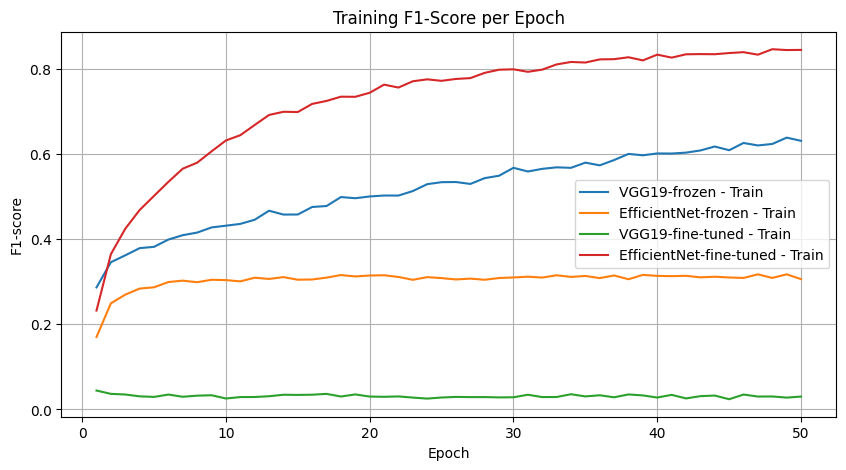

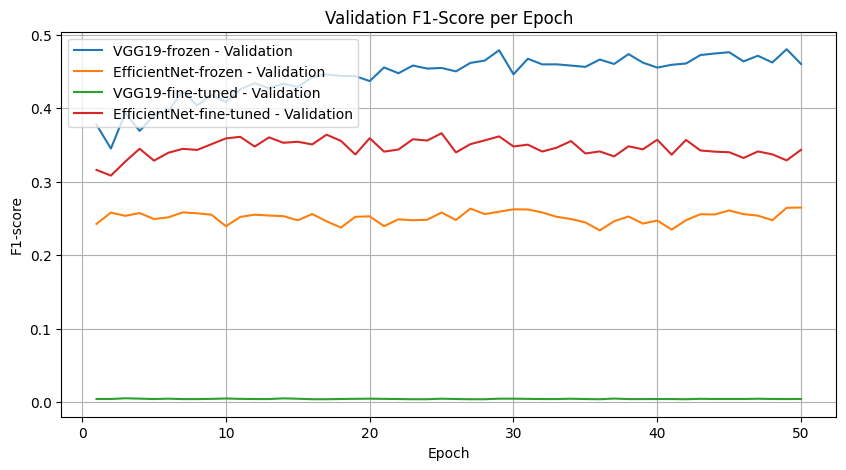


--- Testing VGG19-frozen ---
Test F1-score: 0.4628

--- Testing EfficientNet-frozen ---
Test F1-score: 0.2815

--- Testing VGG19-fine-tuned ---
Test F1-score: 0.0048

--- Testing EfficientNet-fine-tuned ---
Test F1-score: 0.3817


In [42]:
# Plot train and validation f1-scores
plot_f1_scores(f1_scores_dict)

# Test configurations
for name, model in transfer_models.items():
    print(f"\n--- Testing {name} ---")
    test_model(model, test_loader)

Τα αποτελέσματα δείχνουν ότι το μοντέλο **VGG19 με fine-tuning** παρουσίασε την καλύτερη απόδοση στο, υπερέχοντας σημαντικά των υπολοίπων. Αντίθετα, το **EfficientNet (frozen)** εμφάνισε τη χαμηλότερη απόδοση, γεγονός που υποδηλώνει ότι η απλή χρήση της ταξινομητικής κεφαλής χωρίς προσαρμογή του feature extractor δεν επαρκεί. Συμπερασματικά, η **μερική εκπαίδευση των τελευταίων επιπέδων** (fine-tuning) σε ένα δυνατό προεκπαιδευμένο μοντέλο όπως το VGG19 αποδίδει σημαντικά καλύτερα σε σχέση με το πλήρες πάγωμα των βάσεων.


### Διαχείριση μνήμης (TFRecord)

Η φόρτωση δεδομένων με τον τρόπο που το κάναμε παραπάνω στο απλό παράδειγμα υλοποίησης είναι πολύ βολική αλλά δεν είναι αποτελεσματική ως προς τη διαχείριση της μνήμης. Συγκεκριμένα, με τον τρόπο αυτό, τα δεδομένα αποθηκεύονται απευθείας σε μεταβλητές, οι οποίες όλες μαζί καταλαμβάνουν τη RAM της CPU ή της GPU, κάτι που κάνει αδύνατη τη διαχείριση μεγάλων datasets ή τον μεταχηματισμό των δεδομένων όπως όταν κάνουμε αύξηση δεδομένων (data augmentation).

Για να παρακαμφθεί αυτό το πρόβλημα, υπάρχει η δυνατότητα της σειριοποίησης των δεδομένων (serialization) και της αποθήκευσής τους σε αρχεία μεσαίου μεγέθους (κάποιων MB) τα οποία μπορούν να αναγνωστούν γραμμικά.

Το φορμάτ TFRecord είναι ένα φορμάτ που επιτρέπει την αποθήκευση σειράς δυαδικών εγγραφών. Διαβάστε σχετικά για το [TFRecord and tf.Example](https://www.tensorflow.org/tutorials/load_data/tfrecord) και [tf.data: Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data).

Σημειώστε ότι με τη μέθοδο αυτή θα πρέπει να γίνει import η `tensorflow_datasets` και να χρησιμοποιήσουμε την `tfds.load` ώστε να αποθηκευθεί το σύνολο δεδομένων σε αρχεία tfrecord στο δίσκο (δείτε [εδώ](https://colab.research.google.com/github/tensorflow/datasets/blob/master/docs/overview.ipynb) ένα παράδειγμα). Φυσικά μπορούμε να μετατρέψουμε και τα πρωτογενή δεδομένα (raw data) του dataset όπως αρχεία jpg σε φορματ tfrecord όπως [εδώ](https://towardsdatascience.com/working-with-tfrecords-and-tf-train-example-36d111b3ff4d).

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os

# Directory to store TFRecord files
record_dir = './tfrecord_cifar100'
os.makedirs(record_dir, exist_ok=True)

# Load CIFAR-100 dataset
train_ds, test_ds = tfds.load(
    'cifar100',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True
)

def serialize_example(image, label):
    image = tf.image.encode_jpeg(tf.cast(image, tf.uint8))  # still a Tensor
    feature = {
        'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image.numpy()])),
        'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))  
    }
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    return example.SerializeToString()


def write_tfrecord(dataset, filename):
    with tf.io.TFRecordWriter(filename) as writer:
        for image, label in tfds.as_numpy(dataset):
            example = serialize_example(image, label)
            writer.write(example)

# Write the datasets
train_tfrecord_path = os.path.join(record_dir, 'train.tfrecord')
test_tfrecord_path = os.path.join(record_dir, 'test.tfrecord')

print("Writing train TFRecord...")
write_tfrecord(train_ds, train_tfrecord_path)
print("Writing test TFRecord...")
write_tfrecord(test_ds, test_tfrecord_path)

print(f"TFRecords saved to: {record_dir}")


Writing train TFRecord...
Writing test TFRecord...
TFRecords saved to: ./tfrecord_cifar100


Train batch shape: (64, 32, 32, 3)
Train labels: tf.Tensor([41 61 79  2 52 83 98 63 51 15], shape=(10,), dtype=int64)


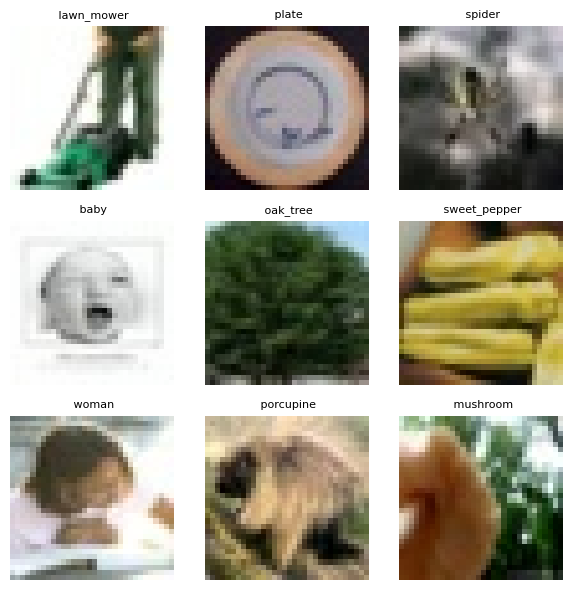

In [36]:
def _parse_function(example_proto):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }
    parsed = tf.io.parse_single_example(example_proto, feature_description)
    image = tf.io.decode_jpeg(parsed['image'], channels=3)
    image = tf.image.resize(image, [32, 32])
    image = tf.cast(image, tf.float32) / 255.0
    label = parsed['label']
    return image, label

# Data augmentation for training
@tf.function
def augment(image, label):
    image = tf.cast(image, tf.float32) * 255.0
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, label

# Create tf.data pipeline

def get_dataset(record_path, batch_size=64, augment_data=False):
    dataset = tf.data.TFRecordDataset(record_path)
    dataset = dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    if augment_data:
        dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# Example usage:
train_aug_ds = get_dataset(train_tfrecord_path, augment_data=True)
test_ds = get_dataset(test_tfrecord_path)

# get class label from class index
def class_label_from_index(fine_category):
  return(CIFAR100_LABELS_LIST[fine_category])

# Peek at a batch and show 9 images in 3x3 grid with labels
for images, labels in train_aug_ds.take(1):
    print("Train batch shape:", images.shape)
    print("Train labels:", labels[:10])

    plt.figure(figsize=(6, 6))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.axis('off')
        plt.title(class_label_from_index(labels[i]), fontsize=8)
    plt.tight_layout()
    plt.show()